## Notebook used for fine-tuning BERT-base on the PMB data

The BERT base model is used as a baseline for this project.



In [ ]:

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Importing all needed libraries for the project
#!/usr/bin/env python

import numpy as np
import tensorflow as tf
import random as python_random

seeds = [42, 1234, 101, 160, 590]


# Make reproducible as much as possible -> should run the experiments with 5 different seeds and report the standard deviations on the scores
np.random.seed(seeds[4])
tf.random.set_seed(seeds[4])
python_random.seed(seeds[4])

model_to_use = 'bert-base-uncased'
batch_size = 32
max_length = 256
epochs = 1

In [ ]:
# Loading all the needed data
import pandas as pd

train_path = '/data/processed/train.csv'
dev_path = '/data/processed/dev.csv'
df_train = pd.read_csv(train_path, index_col=0)
df_dev = pd.read_csv(dev_path, index_col=0)

df_train.head()

,sent,sns,labels,input,offset
0,"A ""girl"" is styling her hair",girl: a young woman,Yes,"A ""girl"" is styling her hair [SEP] a young woman",10129825
1,"A ""girl"" is styling her hair",girl: a youthful female person,No,"A ""girl"" is styling her hair [SEP] a youthful ...",10084295
2,"A ""girl"" is styling her hair",girl: a female human offspring,No,"A ""girl"" is styling her hair [SEP] a female hu...",9992837
3,"A ""girl"" is styling her hair",girl: a girl or young woman with whom a man is...,No,"A ""girl"" is styling her hair [SEP] a girl or y...",10130686
4,"A girl is styling her ""hair""",hair: a covering for the body (or parts of it)...,Yes,"A girl is styling her ""hair"" [SEP] a covering ...",5254795


In [ ]:
#  Data tokenzier
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_to_use)


In [ ]:
#Transform string labels to one-hot encodings
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y_train_bin = encoder.fit_transform(df_train['labels'].to_list())  # Use encoder.classes_ to find mapping back
Y_dev_bin = encoder.fit_transform(df_dev['labels'].to_list())
print(Y_train_bin, type(Y_train_bin))

Y_train = np.asarray([[i] for i in df_train['labels'].to_list()])
Y_dev = np.asarray([[i] for i in df_dev['labels'].to_list()])
print(Y_train)

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]] <class 'numpy.ndarray'>
[['Yes']
 ['No']
 ['No']
 ...
 ['No']
 ['No']
 ['No']]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in df_train['input'].to_list():
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,          # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
train_input_ids = torch.cat(input_ids, dim=0)
train_attention_masks = torch.cat(attention_masks, dim=0)
train_labels = torch.tensor(Y_train_bin)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in df_dev['input'].to_list():
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,          # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
dev_input_ids = torch.cat(input_ids, dim=0)
dev_attention_masks = torch.cat(attention_masks, dim=0)
dev_labels = torch.tensor(Y_dev_bin)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset


# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
dev_dataset = TensorDataset(dev_input_ids, dev_attention_masks, dev_labels)

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = SequentialSampler(train_dataset),  # Training data is already randomized
        batch_size = batch_size  # Train with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
dev_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Model training

In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    model_to_use,
    num_labels = 2,           
    output_attentions = False,      
    output_hidden_states = False,  
)

# Tell pytorch to run this model on the GPU.
model.cuda()

# Resizes input token embeddings matrix to account for the new special tokens
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Embedding(30522, 768, padding_idx=0)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Train

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from torch._C import ListType
from traitlets.traitlets import default
import random
import numpy as np
import os
import glob
from collections import defaultdict

predictions, true_labels = defaultdict(list), defaultdict(list)
val_losses = {}

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
    
# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: tweet ids
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        
        # 'logits' is a 2D tensor with lists of logit lists
        # 'b_labels' is a 1D tensor of the true label
        # 'b_ids' is a 1D tensor of the tweet IDs

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dev_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: tweet ids
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # dit overschrijft nu, maar moet append zijn #TODO
        true_labels[epoch_i].append(label_ids)
        predictions[epoch_i].append(logits)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dev_dataloader)
    val_losses[epoch_i] = avg_val_loss

    # If the avg_val_loss is lower than the previous recorded, save to dict
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.3f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 1 ========
Training...
  Batch    40  of  1,764.    Elapsed: 0:00:47.
  Batch    80  of  1,764.    Elapsed: 0:01:35.
  Batch   120  of  1,764.    Elapsed: 0:02:24.
  Batch   160  of  1,764.    Elapsed: 0:03:14.
  Batch   200  of  1,764.    Elapsed: 0:04:05.
  Batch   240  of  1,764.    Elapsed: 0:04:57.
  Batch   280  of  1,764.    Elapsed: 0:05:49.
  Batch   320  of  1,764.    Elapsed: 0:06:41.
  Batch   360  of  1,764.    Elapsed: 0:07:33.
  Batch   400  of  1,764.    Elapsed: 0:08:25.
  Batch   440  of  1,764.    Elapsed: 0:09:17.
  Batch   480  of  1,764.    Elapsed: 0:10:09.
  Batch   520  of  1,764.    Elapsed: 0:11:01.
  Batch   560  of  1,764.    Elapsed: 0:11:53.
  Batch   600  of  1,764.    Elapsed: 0:12:45.
  Batch   640  of  1,764.    Elapsed: 0:13:37.
  Batch   680  of  1,764.    Elapsed: 0:14:29.
  Batch   720  of  1,764.    Elapsed: 0:15:21.
  Batch   760  of  1,764.    Elapsed: 0:16:12.
  Batch   800  of  1,764.    Elapsed: 0:17:04.
  Batch   840  of

In [ ]:
import pandas as pd

# Display floats with three decimal places.
pd.set_option('precision', 3)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
print(df_stats)

best_val_loss  = min(val_losses, key=val_losses. get)
print(best_val_loss)

       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1              0.309         0.26          0.892       0:37:55         0:03:59
0


([<matplotlib.axis.XTick at 0x7fcd44419220>],
 <a list of 1 Text major ticklabel objects>)

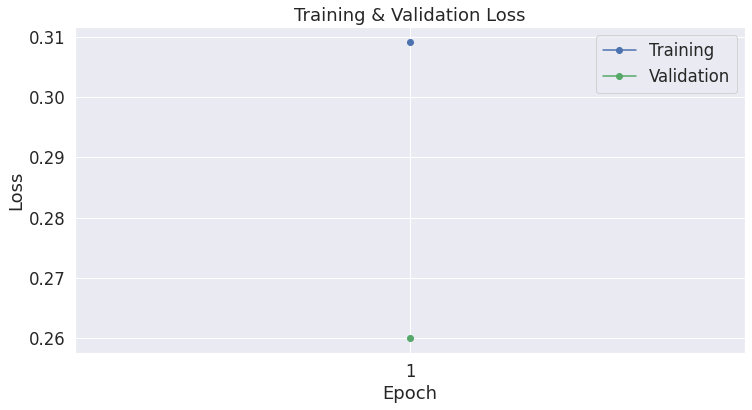

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, epochs + 1)))

#plt.show()


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions[best_val_loss], axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels[best_val_loss], axis=0)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(flat_true_labels, flat_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9402    0.9169    0.9284     11555
           1     0.7489    0.8094    0.7780      3537

    accuracy                         0.8917     15092
   macro avg     0.8445    0.8632    0.8532     15092
weighted avg     0.8954    0.8917    0.8932     15092



In [ ]:
seed_0_clas = classification_report(flat_true_labels, flat_predictions, digits=4)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
test_path = '/data/processed/test.csv'
df_test = pd.read_csv(test_path, index_col=0)
Y_test_bin = encoder.fit_transform(df_test['labels'].to_list())  # Use encoder.classes_ to find mapping back
Y_test = np.asarray([[i] for i in df_test['labels'].to_list()])

# For every sentence...
for sent in df_test['input'].to_list():
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,          # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(input_ids, dim=0)
test_attention_masks = torch.cat(attention_masks, dim=0)
test_labels = torch.tensor(Y_test_bin)

In [ ]:
# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
 # Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

# Tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
true_labels = []
predictions = []

# Evaluate data for one epoch
for batch in test_dataloader:
    
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    #   [3]: tweet ids
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

    # Get the loss and "logits" output by the model. The "logits" are the 
    # output values prior to applying an activation function like the 
    # softmax.
    loss = result.loss
    logits = result.logits
        
    # Accumulate the validation loss.
    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # dit overschrijft nu, maar moet append zijn #TODO
    true_labels.append(label_ids)
    predictions.append(logits)

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)

# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

# Calculate the average loss over all of the batches.
avg_val_loss = total_eval_loss / len(dev_dataloader)
val_losses[epoch_i] = avg_val_loss

# If the avg_val_loss is lower than the previous recorded, save to dict

# Measure how long the validation run took.
validation_time = format_time(time.time() - t0)

print("  Validation Loss: {0:.3f}".format(avg_val_loss))
print("  Validation took: {:}".format(validation_time))

  Accuracy: 0.476
  Validation Loss: 0.122
  Validation took: 0:06:06


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)


print(classification_report(flat_true_labels, flat_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9473    0.9231    0.9350      6071
           1     0.7690    0.8329    0.7997      1867

    accuracy                         0.9019      7938
   macro avg     0.8582    0.8780    0.8674      7938
weighted avg     0.9053    0.9019    0.9032      7938

